# Arrhenius with 5 strain rates

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("mime")
import h5py
from scipy.optimize import curve_fit
import lmfit

colors = ['#bb0000', '#00bb00', "#0000bb", '#bbbb00', '#bb00bb', "#00bbbb", '#bbbbbb', '#770000', '#007700', "#000077", '#777700', '#770077', "#007777", '#777777', '#440000', '#004400', "#000044", '#444400', '#440044', "#0044444", '#444444','#000000']

In [2]:
baseSize = (8, 6)  # Base size of a subplot

def sbPlot(n):
    if (n == 1): return 1, 1
    if (n <= 2): return 1, 2
    if (n <= 4): return 2, 2
    if (n <= 6): return 3, 2
    if (n <= 9): return 3, 3
    if (n <= 12): return 4, 3
    return 0, 0

def sbPlotSize(n):
    x, y = sbPlot(n)
    return baseSize[0] * y, baseSize[1] * x

In [3]:
h5f = h5py.File('../GleebleData.h5','r')
allData = h5f['all'][:]
shortData = h5f['short'][:]
h5f.close()

In [4]:
allData.shape, shortData.shape

((21030, 4), (1080, 4))

Remove first point of each curve, where $\varepsilon^p=0$

In [5]:
allData = allData[allData[:,0] != 0]
shortData = shortData[shortData[:,0]!=0]

Remove data to reconstruct

In [6]:
missed = 5
identData = shortData[shortData[:,1] != missed]
identData.shape

(875, 4)

In [7]:
strains = np.unique(identData[:,0])
allStrains = np.unique(allData[:,0])
epsps = np.unique(identData[:,1])
temperatures = np.unique(identData[:,2])
nEps = len(strains)
nEpsp = len(epsps)
nTemp = len(temperatures)
#strains, epsps, temperatures, nEps, nEpsp, nTemp

# Identification of the Arrhenius parameters
$\sigma^y\left(\varepsilon,\dot\varepsilon,T \right) = \frac{1}{\alpha(\varepsilon)} \ln\left\{\left(\frac{\dot\varepsilon \exp{\left(\frac{Q(\varepsilon)}{RT}\right)}}{A(\varepsilon)}\right)^{\frac{1}{n(\varepsilon)}} + \left[1 + \left(\frac{\dot\varepsilon \exp{\left(\frac{Q(\varepsilon)}{RT}\right)}}{A(\varepsilon)}\right)^{\frac{2}{n(\varepsilon)}}\right]^{\frac{1}{2}}\right\}$

In [8]:
T0 = temperatures[0]
epsp0 = epsps[0]
Tm = 1460
order = 9
polyOrderA = order
polyOrderAlpha = order
polyOrdern = order
polyOrderQ = order

In [9]:
def genParams(params, label, order, srange=None):
    for i in range(order+1):
        if srange==None :
            params.add(label+str(i), value=0)
        else:
            params.add(label+str(i), value=0, min=-srange, max= +srange)

In [10]:
def polyFunc(eps, opt):
    res = 0
    i = 0
    for k in opt.keys():
        res += opt[k]*eps**i
        i += 1
    return res

Parameter $\alpha$

In [11]:
n1 = np.empty((0), float)
for strain in strains:
    nn1 = np.empty((0), float)
    for T in temperatures:
        data = identData[(identData[:,0]==strain) & (identData[:,2]==T)]
        a, b = np.polyfit(np.log(data[:,1]), np.log(data[:,3]), 1)
        nn1 = np.append(nn1, 1/a)
    n1 = np.append(n1, nn1.mean())

beta = np.empty((0), float)
for strain in strains:
    beta1 = np.empty((0), float)
    for T in temperatures:
        data = identData[(identData[:,0]==strain) & (identData[:,2]==T)]
        a, b = np.polyfit(np.log(data[:,1]), (data[:,3]), 1)
        beta1 = np.append(beta1, 1/a)
    beta = np.append(beta, beta1.mean())

alpha = beta / n1
#alpha

Parameter $Q$ and $n$

In [12]:
n = np.empty((0), float)
i = 0
for strain in strains:
    nn1 = np.empty((0), float)
    for T in temperatures:
        data = identData[(identData[:,0]==strain) & (identData[:,2]==T)]
        a, b = np.polyfit(np.log(data[:,1]), np.log(np.sinh(alpha[i]*data[:,3])), 1)
        nn1 = np.append(nn1, 1/a)
    n = np.append(n, nn1.mean())
    i += 1
    
Qf = np.empty((0), float)
i = 0
for strain in strains:
    nn1 = np.empty((0), float)
    for epsp in epsps:
        data = identData[(identData[:,0]==strain) & (identData[:,1]==epsp)]
        a, b =  np.polyfit(1/(data[:,2]+273), np.log(np.sinh(alpha[i]*data[:,3])), 1)
        nn1 = np.append(nn1, a)
    Qf = np.append(Qf, nn1.mean())
    i += 1

R = 8.314
Q = n * R * Qf # For the first range of temperatures
#n, Q

Parameters $\ln(A)$

In [13]:
lnA = np.empty((0), float)
i = 0
for strain in strains:
    nn1 = np.empty((0), float)
    for T in temperatures:
        data = identData[(identData[:,0]==strain) & (identData[:,2]==T)]
        a, b = np.polyfit(np.log(data[:,1]), np.log(np.sinh(alpha[i]*data[:,3])), 1)
        nn1 = np.append(nn1,(Q[i]/(R*(T+273)) - n[i]*b))
    lnA = np.append(lnA, nn1.mean())
    i += 1
#lnA

Evaluation of $\log(A_i)$ parameters

In [14]:
lnAi = lmfit.Parameters()
genParams(lnAi, 'A', polyOrderA)
lnAi

name,value,initial value,min,max,vary
A0,0.00000000,0,-inf,inf,True
A1,0.00000000,0,-inf,inf,True
A2,0.00000000,0,-inf,inf,True
A3,0.00000000,0,-inf,inf,True
A4,0.00000000,0,-inf,inf,True
A5,0.00000000,0,-inf,inf,True
A6,0.00000000,0,-inf,inf,True
A7,0.00000000,0,-inf,inf,True
A8,0.00000000,0,-inf,inf,True
A9,0.00000000,0,-inf,inf,True


In [15]:
def objLnA(opt):
    return lnA - polyFunc(strains, opt)    

In [16]:
fitLna = lmfit.minimize(objLnA, lnAi)
fitLna.params

name,value,standard error,relative error,initial value,min,max,vary
A0,34.7764135,0.53995968,(1.55%),0,-inf,inf,True
A1,-100.977047,35.5361744,(35.19%),0,-inf,inf,True
A2,1553.29358,806.612932,(51.93%),0,-inf,inf,True
A3,-12417.5641,8863.19408,(71.38%),0,-inf,inf,True
A4,49846.4844,54367.4955,(109.07%),0,-inf,inf,True
A5,-103782.400,199036.618,(191.78%),0,-inf,inf,True
A6,95226.7886,444295.578,(466.57%),0,-inf,inf,True
A7,13910.6453,592325.280,(4258.07%),0,-inf,inf,True
A8,-91165.8577,433039.026,(475.00%),0,-inf,inf,True
A9,48147.6696,133487.217,(277.25%),0,-inf,inf,True


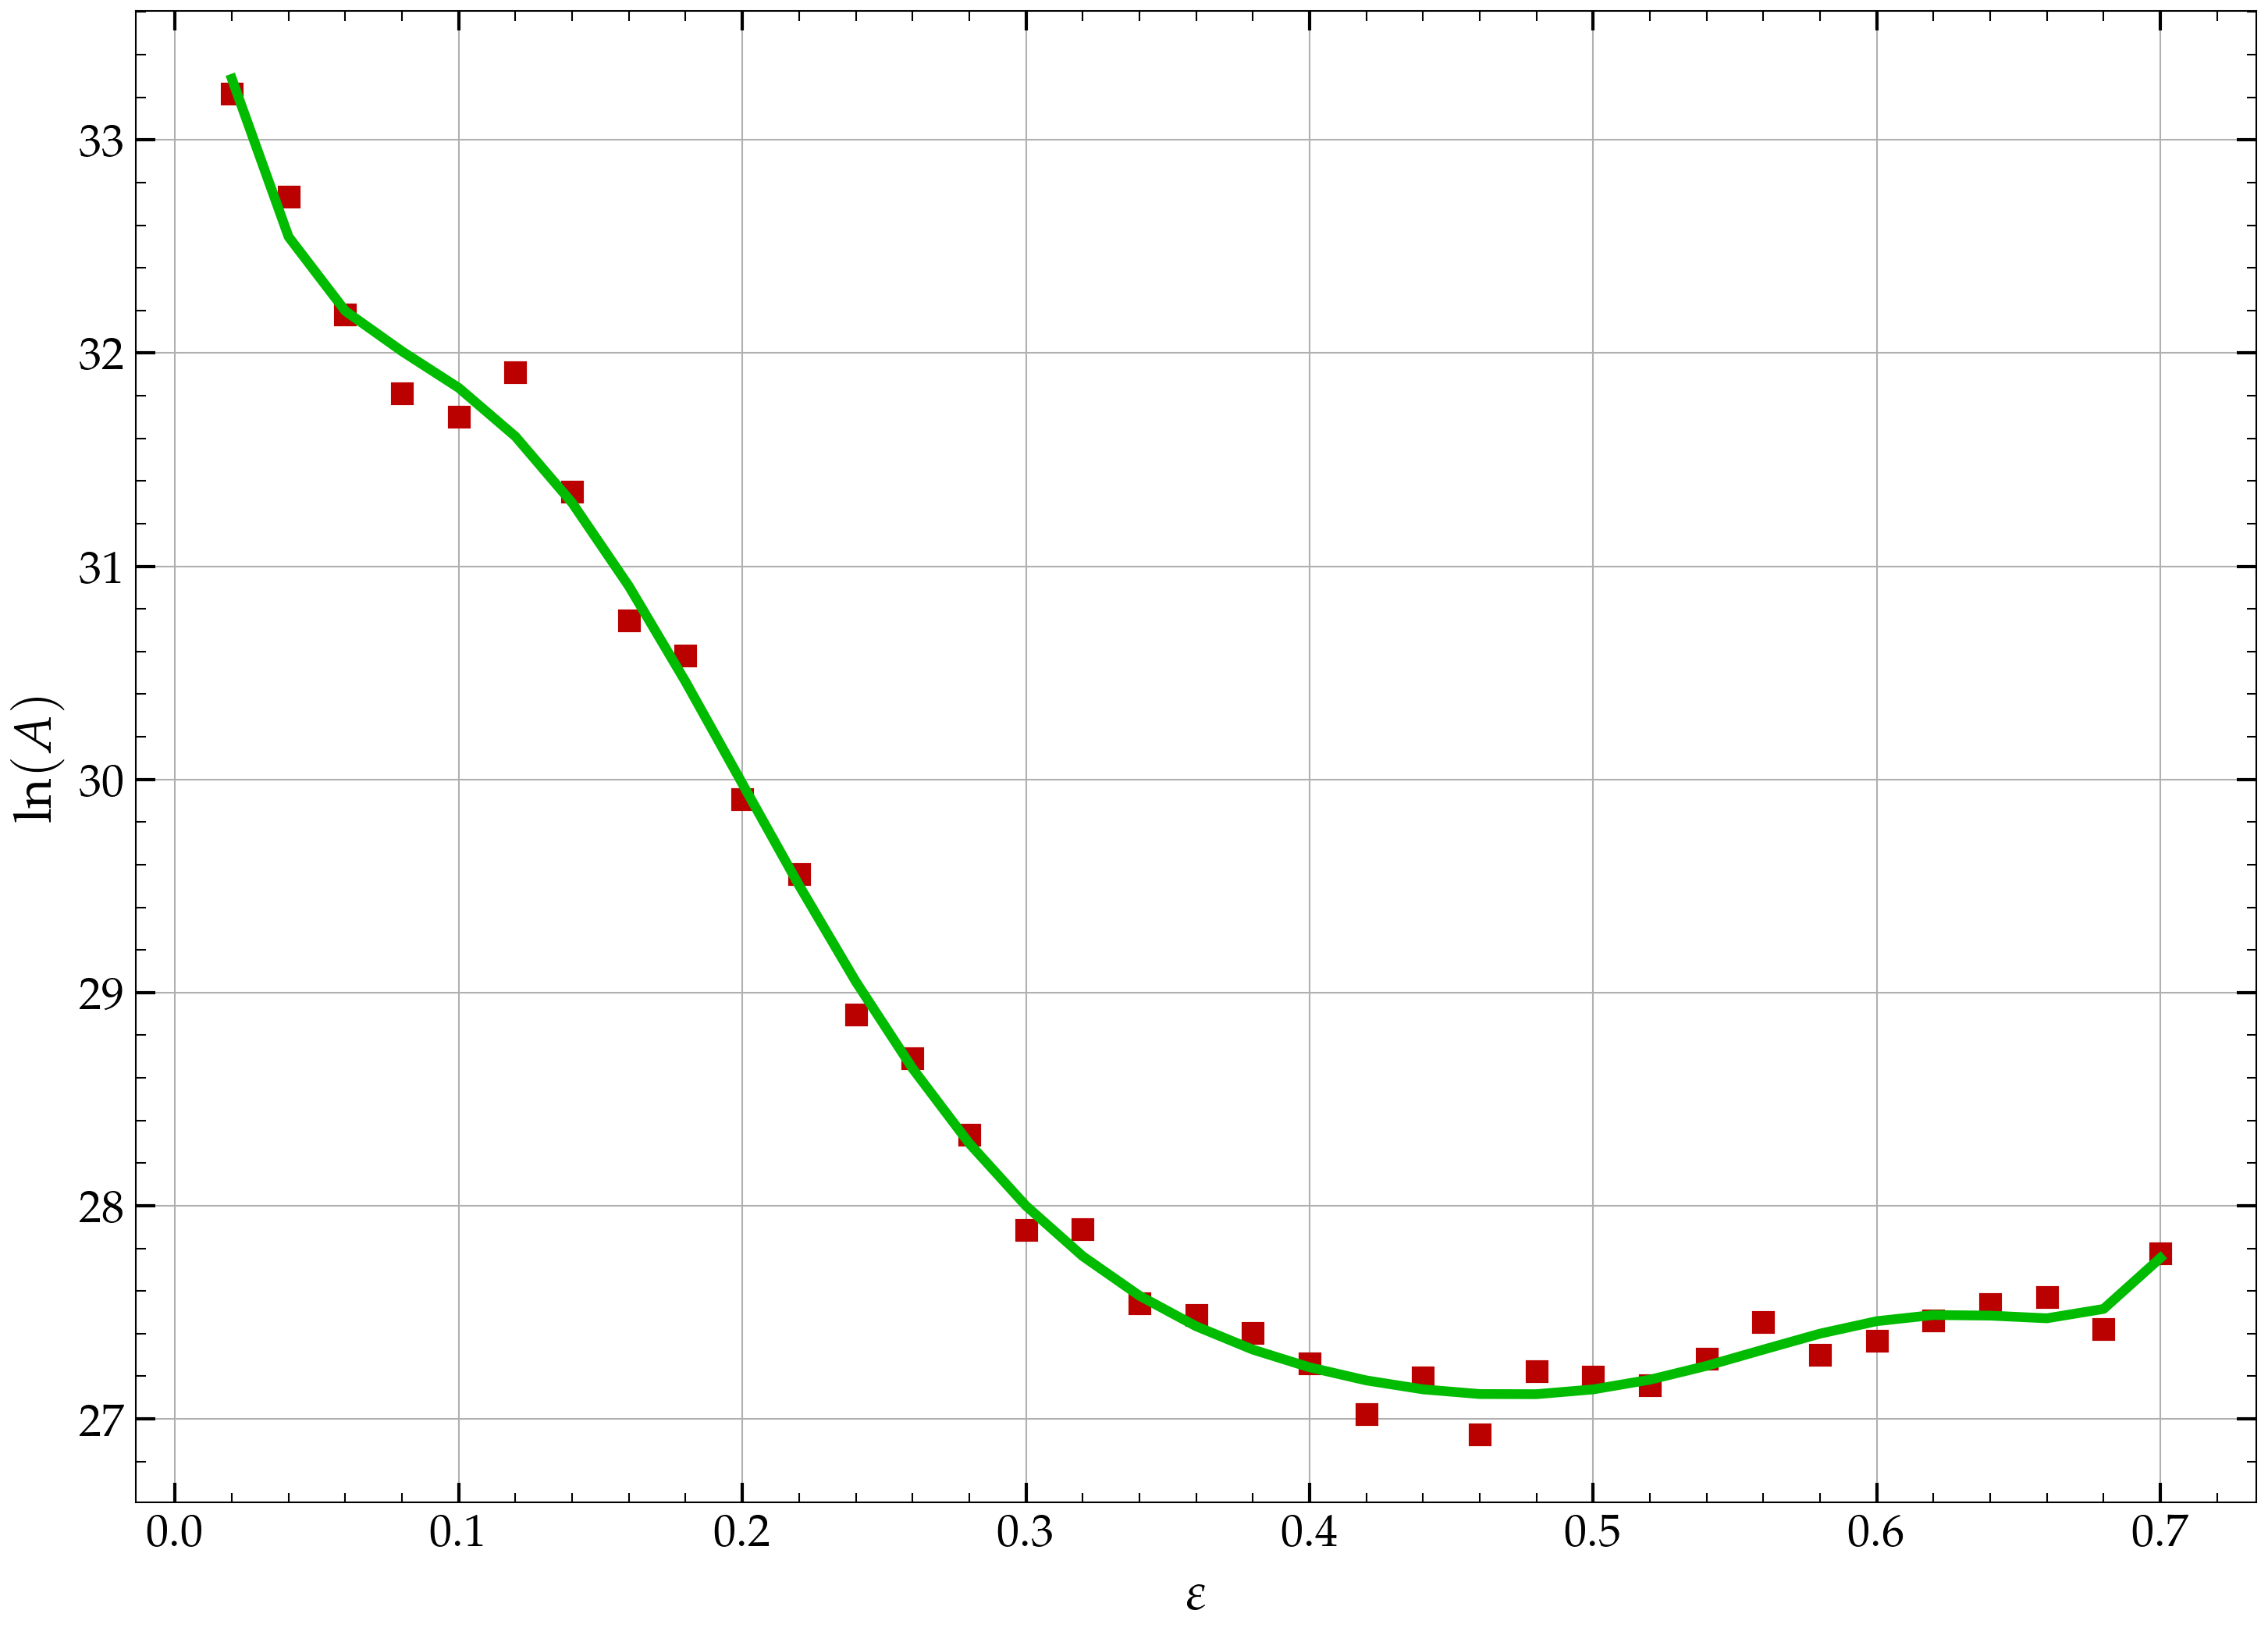

In [17]:
plt.figure()
plt.plot(strains, lnA, colors[0], marker='s', linestyle = 'none')
plt.plot(strains, polyFunc(strains, fitLna.params), colors[1], label=r'$Fitted$', linewidth = 3)
plt.xlabel(r'$\varepsilon$', fontsize = 16) # Labels the x axis
plt.ylabel(r'$\ln (A)$', fontsize = 16) # Labels the y axis
plt.show()

Evaluation of $\alpha_i$ parameters

In [18]:
alphai = lmfit.Parameters()
genParams(alphai, 'alpha', polyOrderAlpha)
alphai

name,value,initial value,min,max,vary
alpha0,0.00000000,0,-inf,inf,True
alpha1,0.00000000,0,-inf,inf,True
alpha2,0.00000000,0,-inf,inf,True
alpha3,0.00000000,0,-inf,inf,True
alpha4,0.00000000,0,-inf,inf,True
alpha5,0.00000000,0,-inf,inf,True
alpha6,0.00000000,0,-inf,inf,True
alpha7,0.00000000,0,-inf,inf,True
alpha8,0.00000000,0,-inf,inf,True
alpha9,0.00000000,0,-inf,inf,True


In [19]:
def objAlpha(opt):
    return alpha - polyFunc(strains, opt)    

In [20]:
fitAlpha = lmfit.minimize(objAlpha, alphai)
fitAlpha.params

name,value,standard error,relative error,initial value,min,max,vary
alpha0,0.04322925,2.1825e-04,(0.50%),0,-inf,inf,True
alpha1,-0.55452878,0.01436963,(2.59%),0,-inf,inf,True
alpha2,6.87106535,0.32627026,(4.75%),0,-inf,inf,True
alpha3,-50.7905644,3.58598575,(7.06%),0,-inf,inf,True
alpha4,235.796893,22.0006604,(9.33%),0,-inf,inf,True
alpha5,-701.691232,80.5534024,(11.48%),0,-inf,inf,True
alpha6,1333.86794,179.828184,(13.48%),0,-inf,inf,True
alpha7,-1563.61527,239.753294,(15.33%),0,-inf,inf,True
alpha8,1028.36018,175.281578,(17.04%),0,-inf,inf,True
alpha9,-290.005802,54.0309298,(18.63%),0,-inf,inf,True


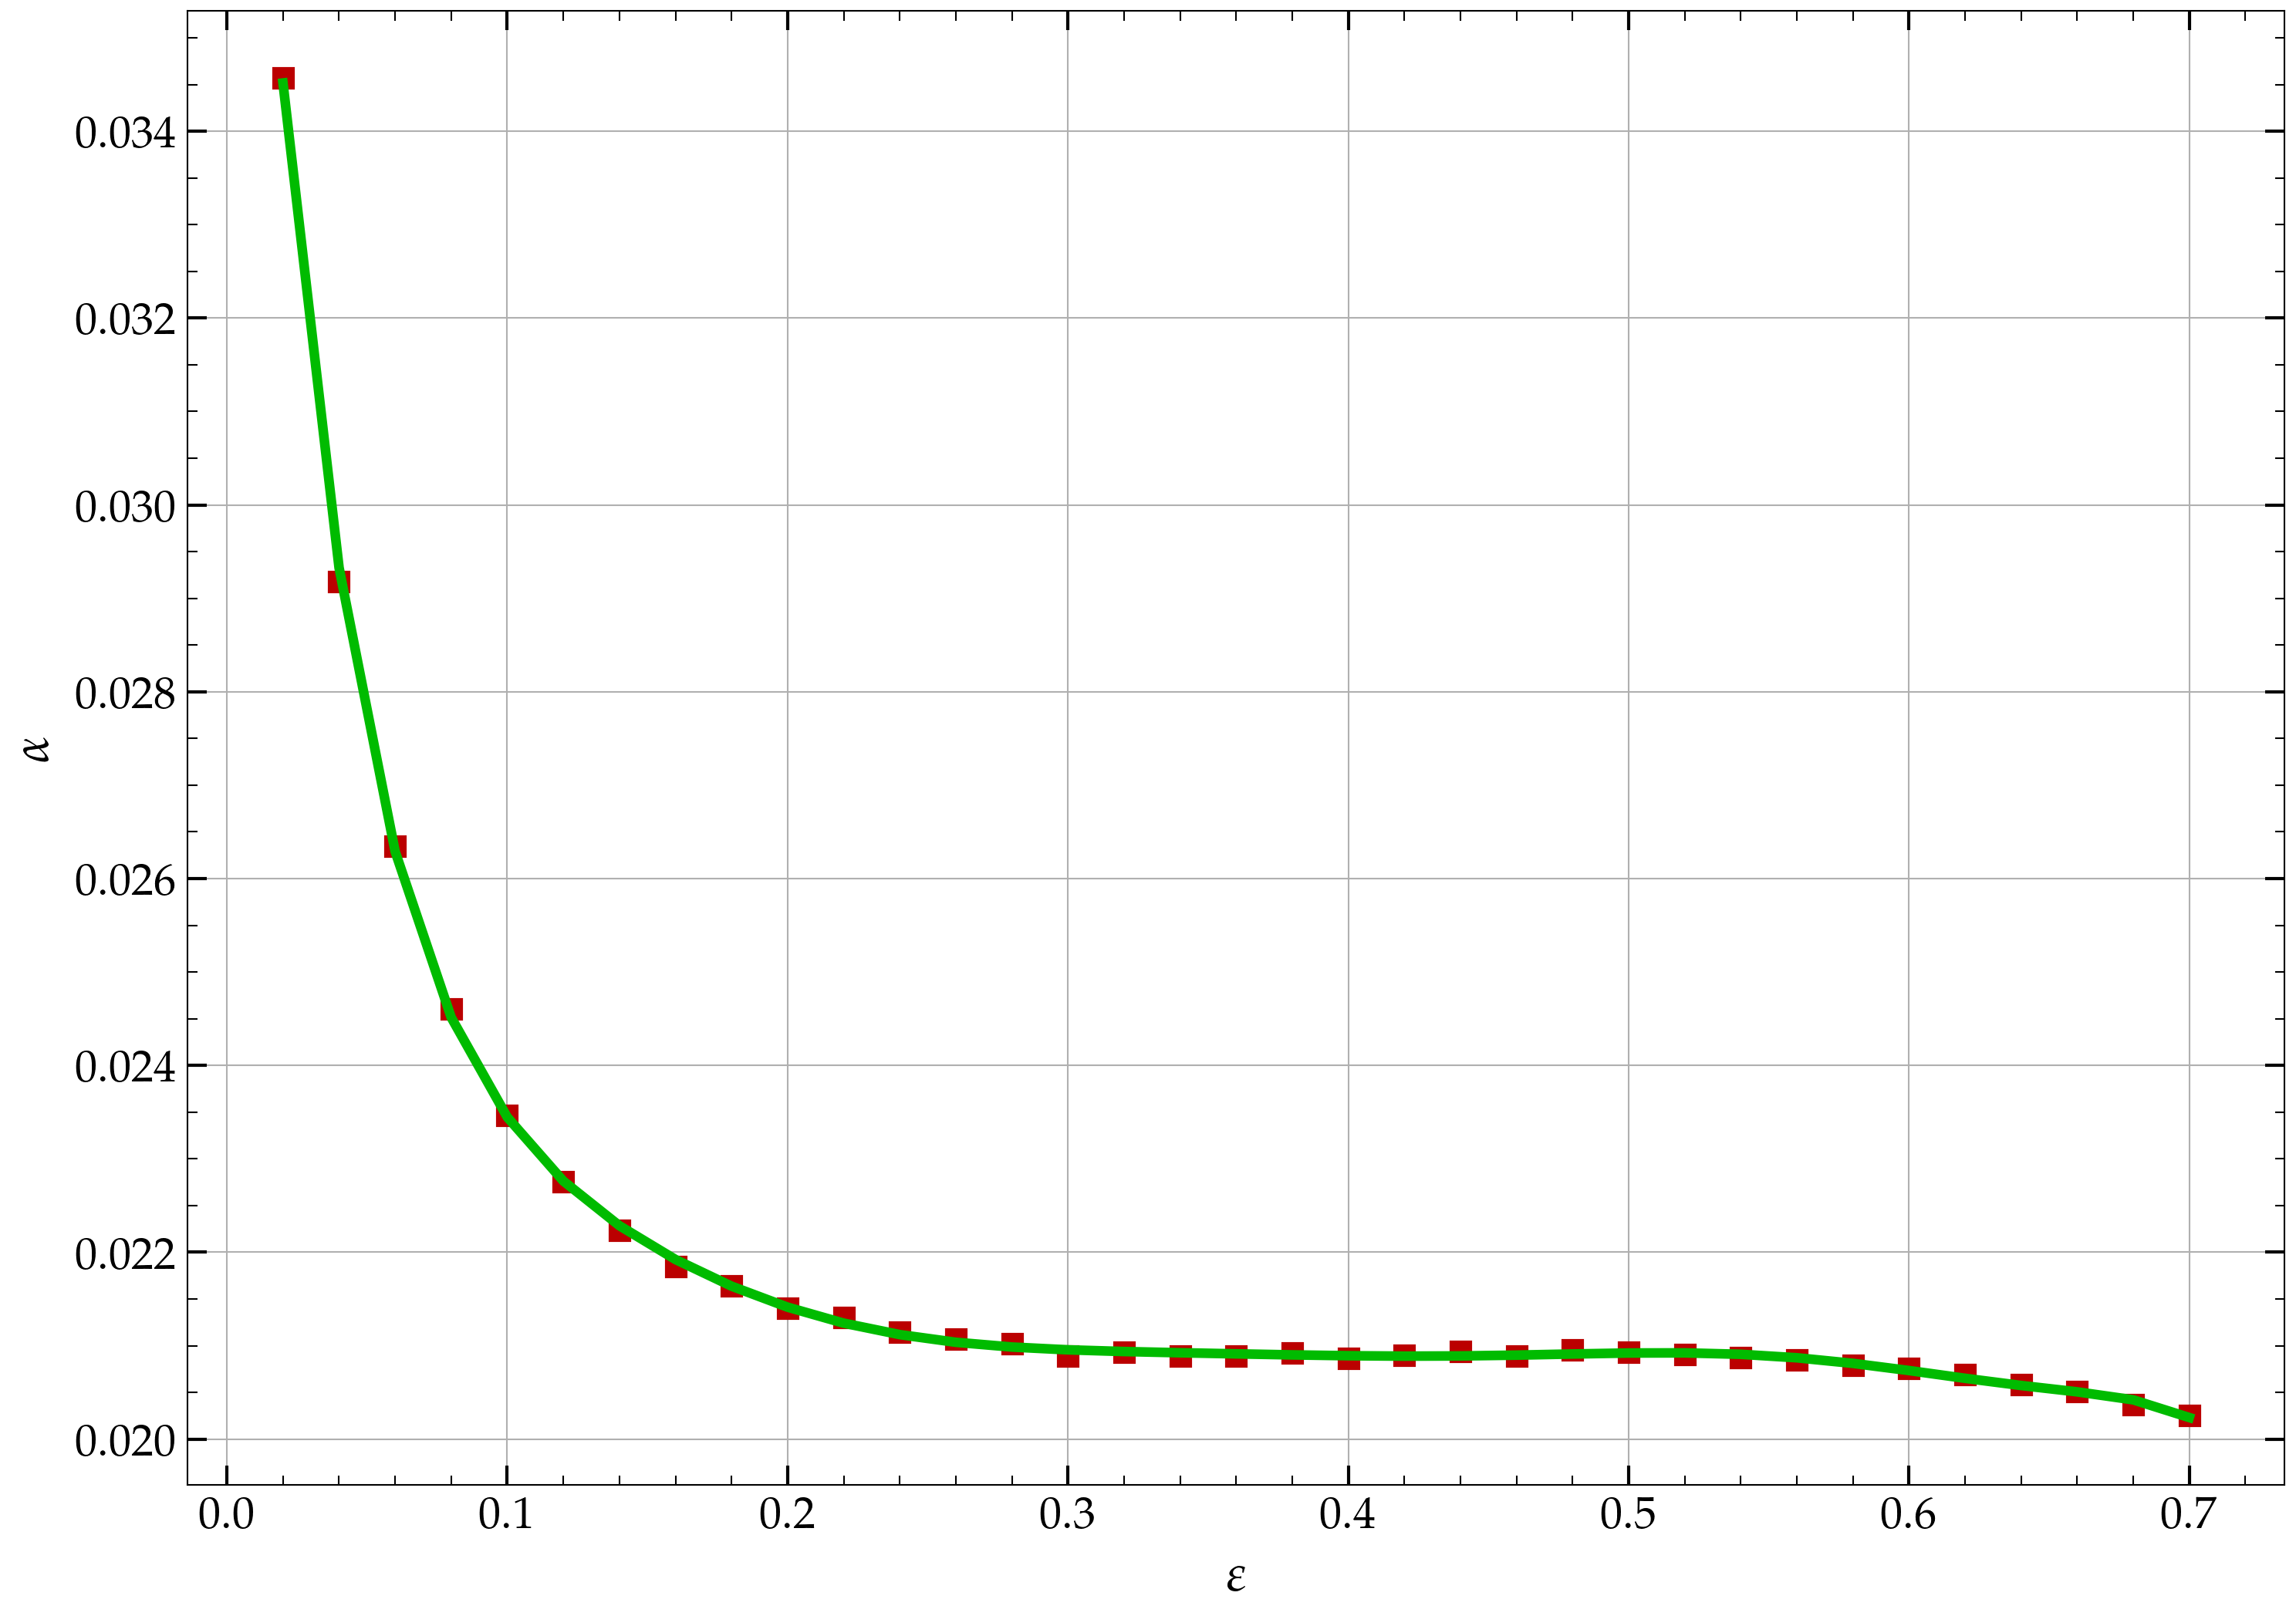

In [21]:
plt.figure()
plt.plot(strains, alpha, colors[0], marker='s', linestyle = 'none')
plt.plot(strains, polyFunc(strains, fitAlpha.params), colors[1], label=r'$Fitted$', linewidth = 3)
plt.xlabel(r'$\varepsilon$', fontsize = 16) # Labels the x axis
plt.ylabel(r'$\alpha$', fontsize = 16) # Labels the y axis
plt.show()

Evaluation of $n_i$ parameters

In [22]:
ni = lmfit.Parameters()
genParams(ni, 'n', polyOrdern)
ni

name,value,initial value,min,max,vary
n0,0.00000000,0,-inf,inf,True
n1,0.00000000,0,-inf,inf,True
n2,0.00000000,0,-inf,inf,True
n3,0.00000000,0,-inf,inf,True
n4,0.00000000,0,-inf,inf,True
n5,0.00000000,0,-inf,inf,True
n6,0.00000000,0,-inf,inf,True
n7,0.00000000,0,-inf,inf,True
n8,0.00000000,0,-inf,inf,True
n9,0.00000000,0,-inf,inf,True


In [23]:
def objN(opt):
    return n - polyFunc(strains, opt)    

In [24]:
fitN = lmfit.minimize(objN, ni)
fitN.params

name,value,standard error,relative error,initial value,min,max,vary
n0,4.68893668,0.05081613,(1.08%),0,-inf,inf,True
n1,2.45649813,3.34406817,(136.13%),0,-inf,inf,True
n2,104.870382,75.8974276,(72.37%),0,-inf,inf,True
n3,-2419.88397,833.886286,(34.46%),0,-inf,inf,True
n4,17558.5753,5114.57254,(29.13%),0,-inf,inf,True
n5,-65875.7041,18722.1589,(28.42%),0,-inf,inf,True
n6,143199.010,41787.6217,(29.18%),0,-inf,inf,True
n7,-182201.808,55704.2758,(30.57%),0,-inf,inf,True
n8,126148.688,40720.0046,(32.28%),0,-inf,inf,True
n9,-36744.2857,12550.8456,(34.16%),0,-inf,inf,True


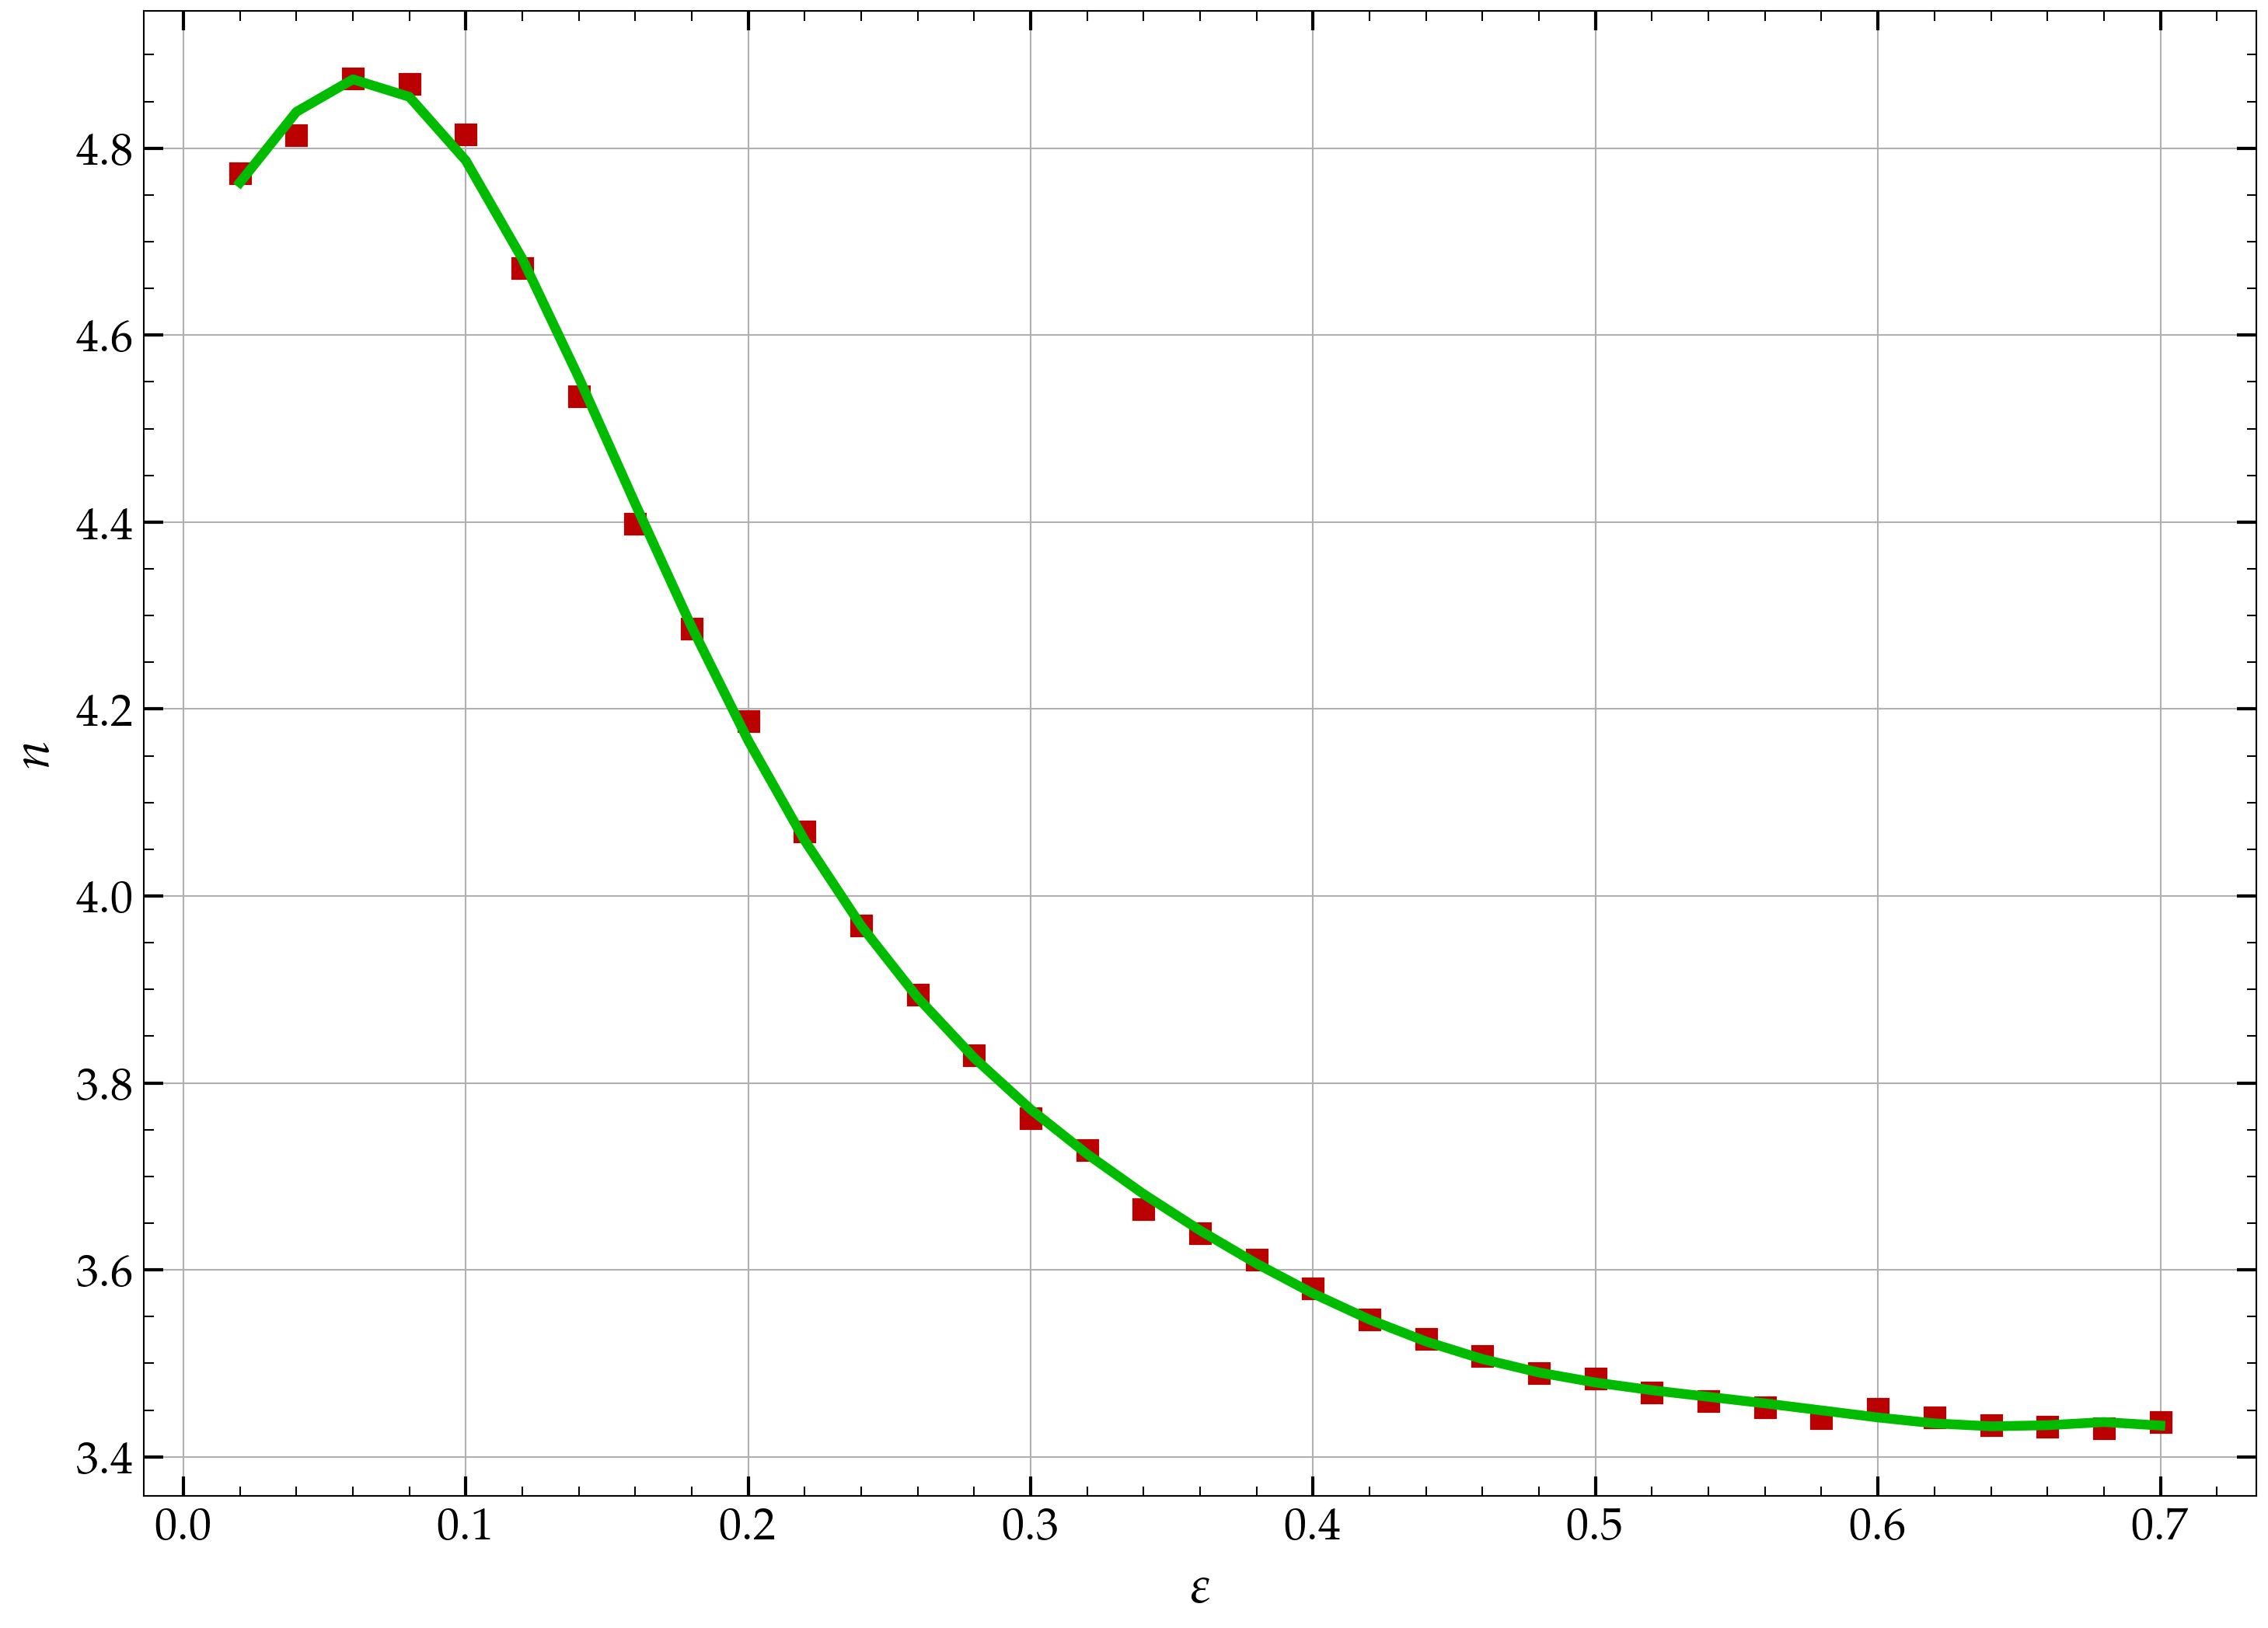

In [25]:
plt.figure()
plt.plot(strains, n, colors[0], marker='s', linestyle = 'none')
plt.plot(strains, polyFunc(strains, fitN.params), colors[1], label=r'$Fitted$', linewidth = 3)
plt.xlabel(r'$\varepsilon$', fontsize = 16) # Labels the x axis
plt.ylabel(r'$n$', fontsize = 16) # Labels the y axis
plt.show()

Evaluation of $Q_i$ parameters

In [26]:
Qi = lmfit.Parameters()
genParams(Qi, 'Q', polyOrderQ)
Qi

name,value,initial value,min,max,vary
Q0,0.00000000,0,-inf,inf,True
Q1,0.00000000,0,-inf,inf,True
Q2,0.00000000,0,-inf,inf,True
Q3,0.00000000,0,-inf,inf,True
Q4,0.00000000,0,-inf,inf,True
Q5,0.00000000,0,-inf,inf,True
Q6,0.00000000,0,-inf,inf,True
Q7,0.00000000,0,-inf,inf,True
Q8,0.00000000,0,-inf,inf,True
Q9,0.00000000,0,-inf,inf,True


In [27]:
def objQ(opt):
    return Q - polyFunc(strains, opt)    

In [28]:
fitQ = lmfit.minimize(objQ, Qi)
fitQ.params

name,value,standard error,relative error,initial value,min,max,vary
Q0,459570.947,6436.44056,(1.40%),0,-inf,inf,True
Q1,-1170425.96,423645.760,(36.20%),0,-inf,inf,True
Q2,17545730.2,9616659.61,(54.81%),0,-inf,inf,True
Q3,-1.3796e+08,1.0567e+08,(76.60%),0,-inf,inf,True
Q4,5.3757e+08,6.4820e+08,(120.58%),0,-inf,inf,True
Q5,-1.0487e+09,2.3730e+09,(226.29%),0,-inf,inf,True
Q6,7.5349e+08,5.2969e+09,(702.98%),0,-inf,inf,True
Q7,6.2783e+08,7.0615e+09,(1124.75%),0,-inf,inf,True
Q8,-1.3941e+09,5.1623e+09,(370.30%),0,-inf,inf,True
Q9,6.6038e+08,1.5912e+09,(240.96%),0,-inf,inf,True


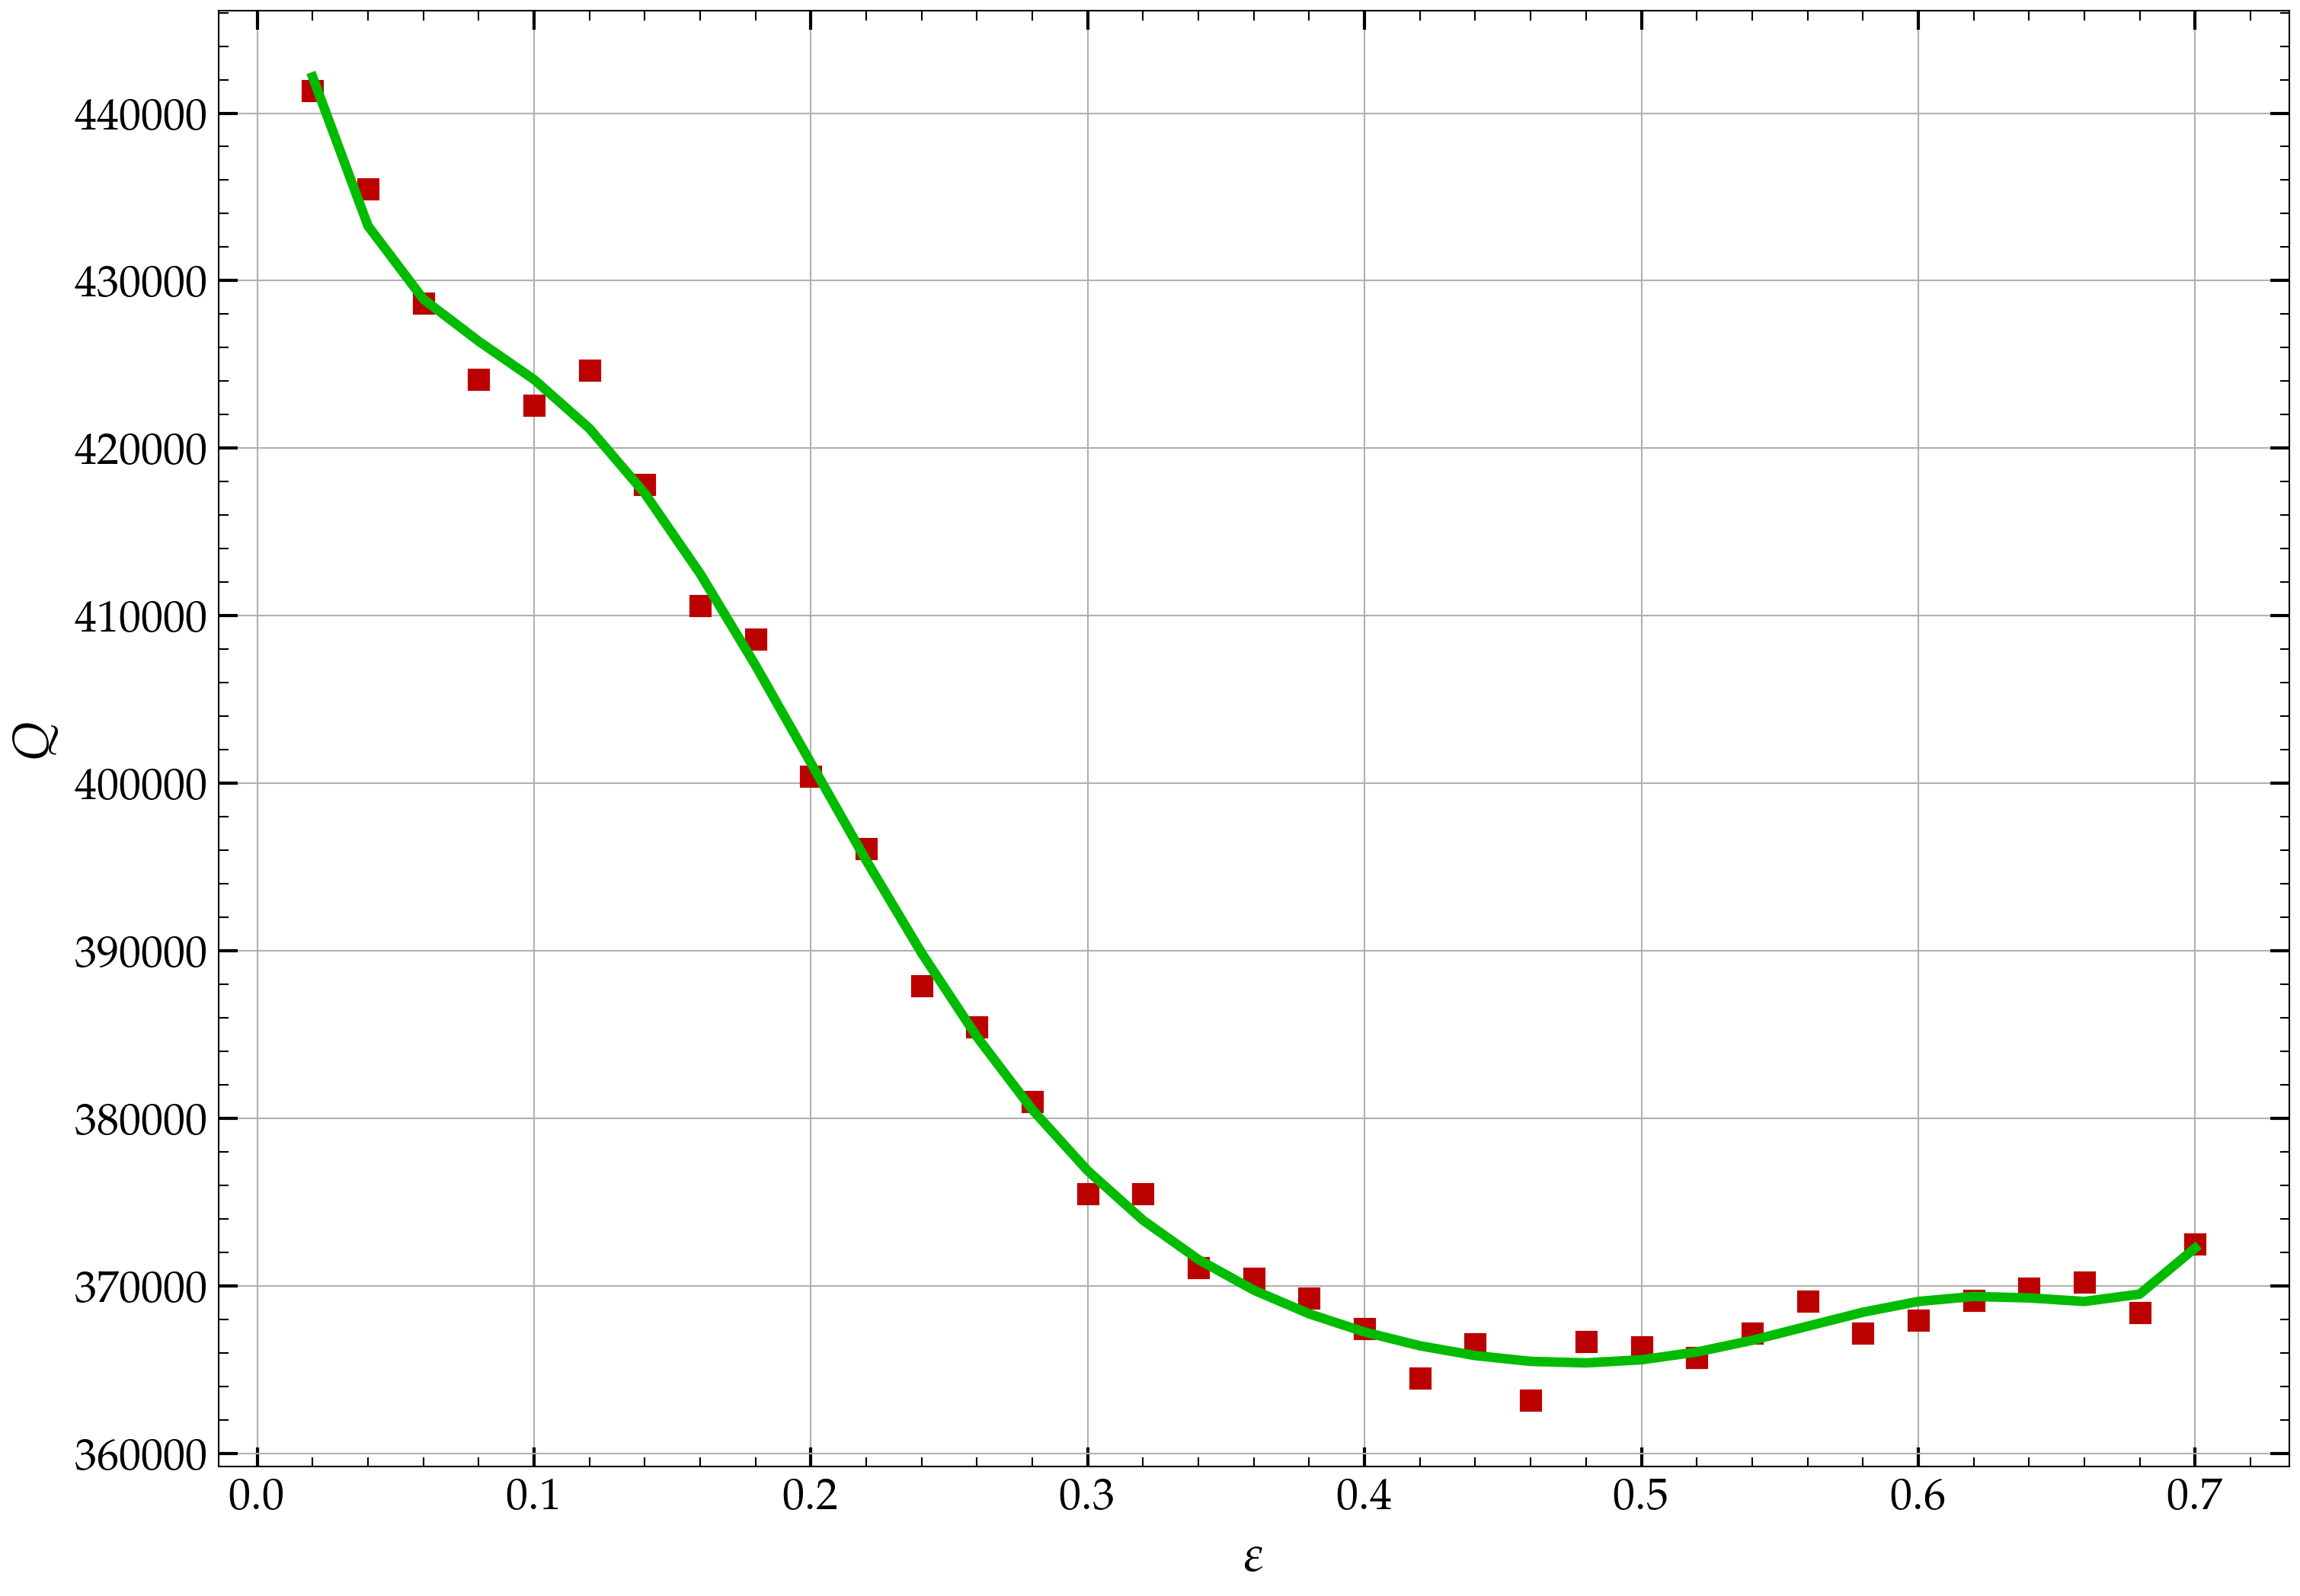

In [29]:
plt.figure()
plt.plot(strains, Q, colors[0], marker='s', linestyle = 'none')
plt.plot(strains, polyFunc(strains, fitQ.params), colors[1], label=r'$Fitted$', linewidth = 3)
plt.xlabel(r'$\varepsilon$', fontsize = 16) # Labels the x axis
plt.ylabel(r'$Q$', fontsize = 16) # Labels the y axis
plt.show()

In [30]:
def Arh(eps, epsp, T):
    parAlpha = polyFunc(eps, fitAlpha.params)
    parQ = polyFunc(eps, fitQ.params)
    parN = polyFunc(eps, fitN.params)
    parA = np.exp(polyFunc(eps, fitLna.params))
    parZ = epsp * np.exp(parQ/(R*(T+273)))
    parZA = parZ/parA
    return (1/parAlpha) * np.log(parZA**(1/parN) + (1 + parZA**(2/parN))**(1/2))

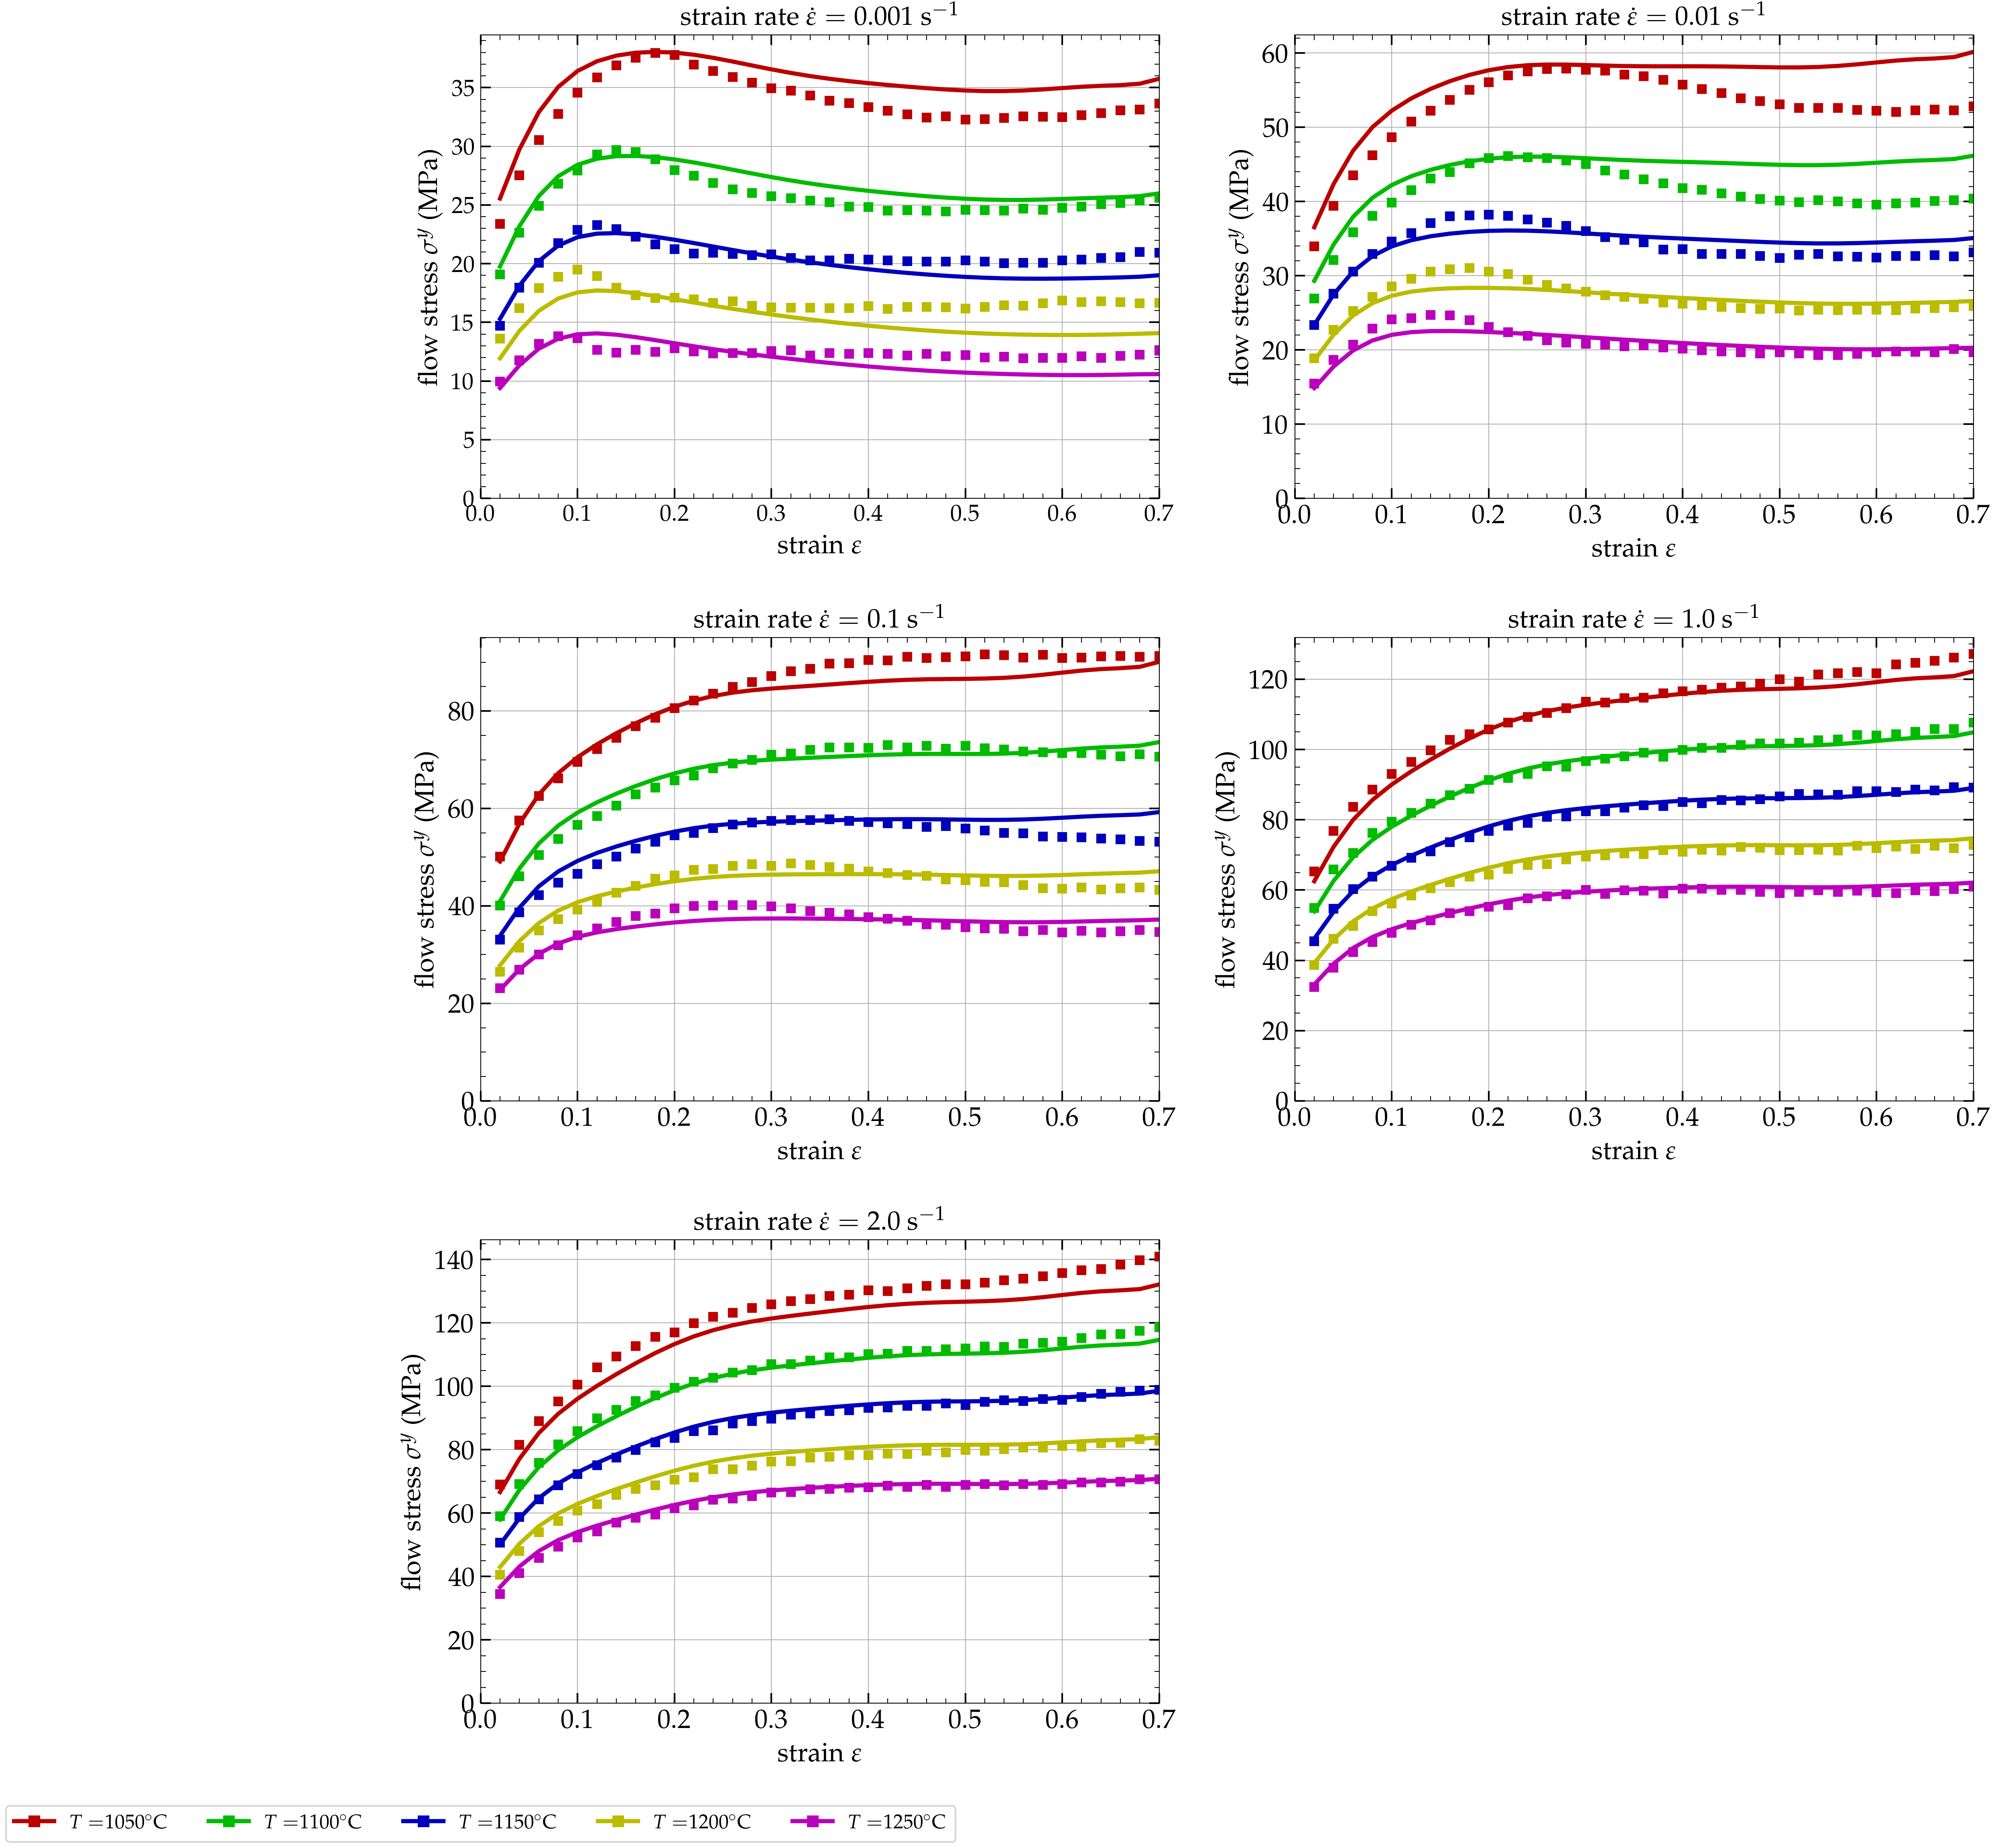

In [31]:
# Plot the curves
from matplotlib.lines import Line2D
def create_dummy_line(**kwds):
    return Line2D([], [], **kwds)

plt.figure(figsize = sbPlotSize(nEpsp))
plt.rc('text', usetex = True)
idx = 1
plt.subplots_adjust(hspace = 0.3)
for epsp in list(epsps):
    xs, ys = sbPlot(nEpsp)
    plt.subplot(xs, ys, idx)
    sbdata = shortData[shortData[:,1]==epsp]
    cl =0
    for temp in list(temperatures):
        sbdata1 = sbdata[sbdata[:,2]==temp]
        plt.plot(sbdata1[:,0], sbdata1[:,3], colors[cl], marker = 's', markersize = 5, linestyle = 'none')
        plt.plot(strains, Arh(strains, epsp, temp), colors[cl], linewidth = 2.5)
        plt.rcParams['xtick.labelsize'] = 16
        plt.rcParams['ytick.labelsize'] = 16
        cl +=1
    plt.xlim(0, 0.7)
    plt.ylim(bottom=0)
    plt.xlabel(r'strain $\varepsilon$', fontsize = 16) # Labels the x axis
    plt.ylabel(r'flow stress $\sigma^y$ (MPa)', fontsize = 16) # Labels the y axis
    plt.title(r'strain rate $\dot{\varepsilon} = ' + str(epsp) + '$ s$^{-1}$', fontsize = 16) # Self explicit command
    idx += 1
    
legendLines = []
cl = 0
for temp in list(temperatures):
    legendLines.append((r'$T=$' + str(int(temp)) + r'$^{\circ}$C', {'color':colors[cl], 'linestyle':'-', 'linewidth':2.5, 'marker':'s'}))
    cl += 1

plt.legend([create_dummy_line(**l[1]) for l in legendLines],[l[0] for l in legendLines], 
           loc = 'upper center', fontsize = 12, ncols = 5, bbox_to_anchor = (0.0, -0.2), shadow = False)

plt.savefig("CompExpAR-5e.svg")
plt.show()

In [32]:
ARstress = Arh(allData[:,0], allData[:,1], allData[:,2])

In [33]:
data = np.concatenate((allData[:,0:3],ARstress.reshape((ARstress.shape[0],1))),axis=1)
h5f = h5py.File('AR-5e.h5','w')
h5f.create_dataset('data', data = data)
h5f.close()

In [34]:
EAAR = np.sum(np.abs((allData[:,3] - ARstress)/(allData[:,3])))*100/ARstress.shape[0]
print("EAAR = %.2f" %(EAAR) + ' %')

EAAR = 3.95 %


In [35]:
RMSE = np.sqrt(np.sum((allData[:,3] - ARstress)**2)/ARstress.shape[0])
print('RMSE = %.2f' %(RMSE)+' MPa')

RMSE = 2.68 MPa


In [36]:
def outOf(val, i):
    if ((val<-i) or (val>i)): return True
    return False

def conv (v, d):
    va = abs(v)
    e = int(np.log10(va))
    if (va < 1): e-=1
    if outOf(e,2):
        a = v * 10**(-e)
        v = np.round(a * 10**d)/10**d
        return str(v)+'\\times 10^{'+str(e)+'}'
    v = np.round(v * 10**d)/10**d
    return str(v)

l1=list(fitAlpha.params.values())
l2=list(fitQ.params.values())
l3=list(fitLna.params.values())
l4=list(fitN.params.values())
for i in range(np.max([len(l1),len(l2),len(l3),len(l4)])):
    s = ''
    if i < (len(l1)):
        s += l1[i].name+'='+ str(conv(l1[i].value,4))
    s+=' & '
    if i < (len(l2)):
        s += l2[i].name+'='+ str(conv(l2[i].value/1e6,4))
    s+=' & '
    if i < (len(l3)):
        s += l3[i].name+'='+ str(conv(l3[i].value,4))
    s+=' & '
    if i < (len(l4)):
        s += l4[i].name+'='+ str(conv(l4[i].value,4))
    s+='\\\\'    
    print(s)

alpha0=0.0432 & Q0=0.4596 & A0=34.7764 & n0=4.6889\\
alpha1=-0.5545 & Q1=-1.1704 & A1=-100.977 & n1=2.4565\\
alpha2=6.8711 & Q2=17.5457 & A2=1.5533\times 10^{3} & n2=104.8704\\
alpha3=-50.7906 & Q3=-137.9583 & A3=-1.2418\times 10^{4} & n3=-2.4199\times 10^{3}\\
alpha4=235.7969 & Q4=537.5739 & A4=4.9846\times 10^{4} & n4=1.7559\times 10^{4}\\
alpha5=-701.6912 & Q5=-1.0487\times 10^{3} & A5=-1.0378\times 10^{5} & n5=-6.5876\times 10^{4}\\
alpha6=1.3339\times 10^{3} & Q6=753.4905 & A6=9.5227\times 10^{4} & n6=1.432\times 10^{5}\\
alpha7=-1.5636\times 10^{3} & Q7=627.828 & A7=1.3911\times 10^{4} & n7=-1.822\times 10^{5}\\
alpha8=1.0284\times 10^{3} & Q8=-1.3941\times 10^{3} & A8=-9.1166\times 10^{4} & n8=1.2615\times 10^{5}\\
alpha9=-290.0058 & Q9=660.3816 & A9=4.8148\times 10^{4} & n9=-3.6744\times 10^{4}\\
